# Error Analysis

In [1]:
import pickle 
import random
from random import sample 
import torch
import nlp
from transformers import T5ForConditionalGeneration, T5Tokenizer
from tqdm.auto import tqdm
from sklearn import metrics
import pandas as pd


from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline

import venn

device = 'cuda' if torch.cuda.is_available else 'cpu'

random.seed(a=42)

## Models to evaluate

1. **T5 Base**: Finetuned Commonsense QA for 10 epochs 
2. **T5 Base + Social I QA**: Finetuned on Social I QA (4 epochs, batch 8, lr 1e-4), then finetuned on Commonsense QA (10 epochs, batch size 8, learning rate 1e-4, wu 0)
3. **T5 Base + Cosmos QA**: Finetuned on Cosmos QA (3 epochs, batch size 8, learning rate 5e-5), then finetuned on Commonsense QA (10 epochs, batch size 8, learning rate = 5e-5)
4. **T5 Base + hellaswag**:


In [2]:
# Load the validation dataset. Common to all analyses.
valid_dataset = torch.load('../data/commonsense_qa/valid_data.pt')
dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size = 32)

In [3]:
def predict_results(model_and_tokenizer_location):
    # Load the pretrained model
    model = T5ForConditionalGeneration.from_pretrained(model_and_tokenizer_location)
    tokenizer = T5Tokenizer.from_pretrained(model_and_tokenizer_location)

    # Generate predictions
    predictions = []
    targets = []
    model.to(device)    
    model.eval()
    with torch.no_grad():
        for batch in tqdm(dataloader):
            prediction = model.generate(input_ids = batch['input_ids'].to(device), 
                              attention_mask = batch['attention_mask'].to(device),
                              max_length = 16)
            prediction = [tokenizer.decode(ids) for ids in prediction]
            target = [tokenizer.decode(ids) for ids in batch['target_ids']]

            predictions.extend(prediction)
            targets.extend(target)
            
    return(predictions, targets, tokenizer)

In [4]:
class Answers:
    
    def __init__(self, predictions, targets, tokenizer):
        self.accuracy = metrics.accuracy_score(targets, predictions)
        
        # Find index of wrong answers 
        self.incorrect_idxs = [i for i, prediction in enumerate(predictions) 
                               if prediction != targets[i]]
        
        self.qq={}
        self.target_ans={}
        self.predicted_ans={}
        
        self.size = 0
        
        for incorrect_idx in self.incorrect_idxs:
            self.qq[incorrect_idx]            = tokenizer.decode(valid_dataset[incorrect_idx]['input_ids'] )
            self.target_ans[incorrect_idx]    = tokenizer.decode(valid_dataset[incorrect_idx]['target_ids'])
            self.predicted_ans[incorrect_idx] = predictions[incorrect_idx]
            self.size += 1
            
        self.get_error_df()
        
    def get_example(self, incorrect_idx):
        print(incorrect_idx, "-", self.qq[incorrect_idx].replace("options:", "\n\noptions:")\
             .replace("A:", "\nA:")\
             .replace("B:", "\nB:")\
             .replace("C:", "\nC:")\
             .replace("D:", "\nD:")\
             .replace("E:", "\nE:"))
        print("\n==> Correct ans:  ",   self.target_ans[incorrect_idx])
        print("==> Predicted ans:", self.predicted_ans[incorrect_idx])
        
    def get_error_df(self):
        drows=[]
        for idx in self.incorrect_idxs:
            drow=[]
            drow.append(idx)
            drow.extend(self.qq[idx]\
                 .replace("A:", "\nA:")\
                 .replace("B:", "\nB:")\
                 .replace("C:", "\nC:")\
                 .replace("D:", "\nD:")\
                 .replace("E:", "\nE:").split("\n"))
            drow.append(self.target_ans[idx])
            drow.append(self.predicted_ans[idx])
            drows.append(drow)

        self.error_df = pd.DataFrame(drows, 
                                     columns=["idx", "question", 
                                              "A", "B", "C", "D", "E", 
                                              "target", "predicted"]).set_index("idx")
        

## T5 Base

In [8]:
modeldir = "./models/commonsense_qa/10_epochs/"
(predictions, targets, tokenizer) = predict_results(modeldir)
t5_base_ans = Answers(predictions, targets, tokenizer)
with open('t5_base_ans', 'wb') as f:
    pickle.dump(t5_base_ans, f)

## T5 Base + Hella SWAG

In [9]:
modeldir = "./models/hellaswag/commonsense_qa/"
(predictions, targets, tokenizer) = predict_results(modeldir)
t5_hel_ans = Answers(predictions, targets, tokenizer)
with open('t5_hel_ans', 'wb') as f:
    pickle.dump(t5_hel_ans, f)

## T5 Base + Cosmos QA

In [11]:
modeldir = "./models/cs_on_cosmos/batch_8_lr_5e-5_wu_0_epochs10"
t5_cos_predictions, t5_cos_targets, t5_cos_tokenizer = predict_results(modeldir)

In [52]:
t5_cos_ans = Answers(t5_cos_predictions, t5_cos_targets, t5_cos_tokenizer)

In [54]:
t5_cos_ans.get_example(2)

2 - question: Where would you find magazines along side many other printed works? 

options: 
A: doctor 
B: bookstore 
C: market 
D: train station 
E: mortuary

==> Predicted ans: C: market
==> Correct ans:   B: bookstore


In [63]:
with open('t5_cos_ans', 'wb') as f:
    pickle.dump(t5_cos_ans, f)

## T5 base + Social I QA

In [55]:
modeldir = "./models/cs_on_social/4_epochs_nonstop_batch8_lr1e-4_cs_10_e_b8_1e-4_wu0_300cp"
t5_so_predictions, t5_so_targets, t5_so_tokenizer = predict_results(modeldir)

In [56]:
t5_so_ans = Answers(t5_so_predictions, t5_so_targets, t5_so_tokenizer)

In [62]:
with open('t5_so_ans', 'wb') as f:
    pickle.dump(t5_so_ans, f)

## Data load

In [100]:
# T5 base

with open("t5_base_ans", 'rb') as f:
    t5_base_ans = pickle.load(f)
    
t5_base_ans.get_error_df()
len(t5_base_ans.incorrect_idxs)

458

In [101]:
with open("t5_so_ans", 'rb') as f:
    t5_so_ans = pickle.load(f)
    
t5_so_ans.get_error_df()

len(t5_so_ans.incorrect_idxs)

465

In [102]:
with open("t5_cos_ans", 'rb') as f:
    t5_cos_ans = pickle.load(f)
    
t5_cos_ans.get_error_df()
len(t5_cos_ans.incorrect_idxs)

454

In [103]:
# T5 + Hella swag

with open("t5_hel_ans_wu", 'rb') as f:
    t5_hel_ans = pickle.load(f)
    
t5_hel_ans.get_error_df()
len(t5_hel_ans.incorrect_idxs)

440

# Model Comparison

We have four models here. Let's see how many errors they share. This is purely based on getting a question correct or wrong. 

In [27]:
def venn_2_models(model_a, model_b,
                      a_name="Model A", b_name="Model B",
                      inputclass_answers=True):
    if inputclass_answers:
        A = set(model_a.incorrect_idxs)
        B = set(model_b.incorrect_idxs)
    else:
        A = set(model_a)
        B = set(model_b)
    
    AB = A.intersection(B)
    
    venn2(subsets = (len(A-B), 
                     len(B-A),
                     len(AB)), 
    set_labels = (a_name, b_name))


In [28]:
def venn_3_models(model_a, model_b, model_c,
                     a_name="Model A", b_name="Model B", c_name= "Model C",
                     inputclass_answers=True):
    if inputclass_answers:
        A = set(model_a.incorrect_idxs)
        B = set(model_b.incorrect_idxs)
        C = set(model_c.incorrect_idxs)
    else:
        A = set(model_a)
        B = set(model_b)
        C = set(model_c)
    
    AB = A.intersection(B)
    AC = A.intersection(C)
    BC = B.intersection(C)
    ABC = AB.intersection(C)
    
    venn3(subsets = (len(A-B-C), 
                     len(B-A-C),
                     len(AB-C),
                     len(C-A-B),
                     len(AC-B),
                     len(BC-A),
                     len(ABC)
                    ), 
         set_labels = (a_name, b_name, c_name))



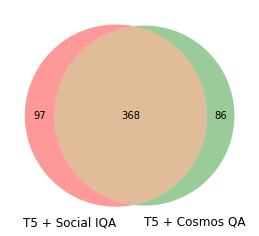

In [29]:
venn_2_models(t5_so_ans, t5_cos_ans,
               "T5 + Social IQA",
               "T5 + Cosmos QA")

## 4 way venn


In [92]:
A = set(t5_base_ans.incorrect_idxs)
B = set(t5_so_ans.incorrect_idxs)
C = set(t5_cos_ans.incorrect_idxs)
D = set(t5_hel_ans.incorrect_idxs)

for a in [A, B, C, D]:
    print(len(a))

458
465
454
440


In [94]:
labels = venn.get_labels([A, B, C, D], fill=["number"])
new_labels = {}

for k, v in labels.items():
    ds_label = \
        "B"*int(k[0])+\
        "S"*int(k[1])+\
        "C"*int(k[2])+\
        "H"*int(k[3])
    new_labels[k] = ds_label + ": " + v
    
new_labels

{'0001': 'H: 28 ',
 '0010': 'C: 20 ',
 '0011': 'CH: 7 ',
 '0100': 'S: 48 ',
 '0101': 'SH: 14 ',
 '0110': 'SC: 14 ',
 '0111': 'SCH: 22 ',
 '1000': 'B: 21 ',
 '1001': 'BH: 11 ',
 '1010': 'BC: 30 ',
 '1011': 'BCH: 29 ',
 '1100': 'BS: 13 ',
 '1101': 'BSH: 22 ',
 '1110': 'BSC: 25 ',
 '1111': 'BSCH: 307 '}

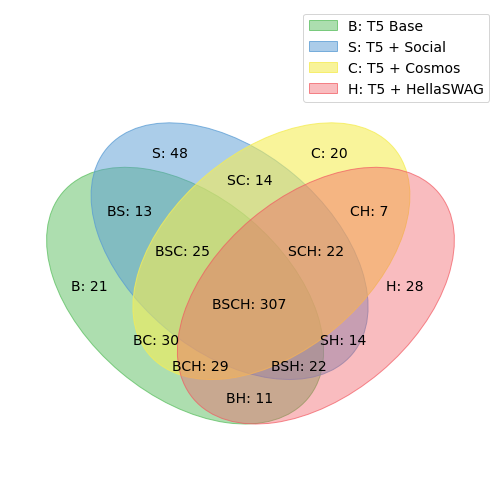

In [95]:
fig, ax = venn.venn4(new_labels, names=['B: T5 Base', 
                                        'S: T5 + Social', 
                                        'C: T5 + Cosmos', 
                                        'H: T5 + HellaSWAG'])
fig.show()

This is based on correct/incorrect only. Let’s see how it changes once we add in the unique predictions too.

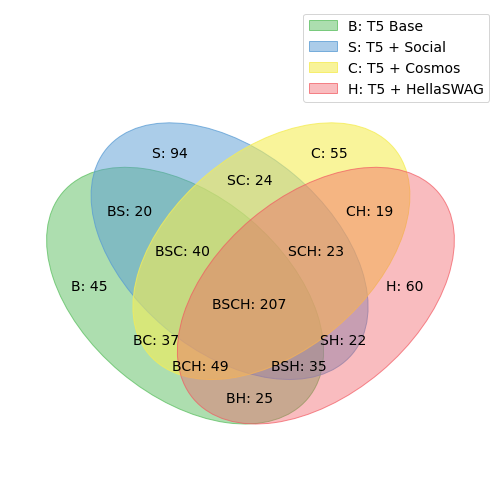

In [96]:
A = set(t5_base_ans.predicted_ans.items())
B = set(t5_so_ans.predicted_ans.items())
C = set(t5_cos_ans.predicted_ans.items())
D = set(t5_hel_ans.predicted_ans.items())

labels = venn.get_labels([A, B, C, D], fill=["number"])

new_labels = {}

for k, v in labels.items():
    ds_label = \
        "B"*int(k[0])+\
        "S"*int(k[1])+\
        "C"*int(k[2])+\
        "H"*int(k[3])
    new_labels[k] = ds_label + ": " + v
    
fig, ax = venn.venn4(new_labels, names=['B: T5 Base', 
                                        'S: T5 + Social', 
                                        'C: T5 + Cosmos', 
                                        'H: T5 + HellaSWAG'])
fig.show()

## Detailed View at Errors

### Incorrect Ans

Let's look at the questions that only one model got wrong that other models got right.


### Base

In [53]:
incorr = \
    set(t5_base_ans.incorrect_idxs) - \
    set(t5_so_ans.incorrect_idxs  ) - \
    set(t5_cos_ans.incorrect_idxs ) -\
    set(t5_hel_ans.incorrect_idxs )

print(len(incorr))
t5_base_ans.error_df.loc[sample(incorr, 17)].to_csv("clip.csv")

21


### Social

In [64]:
incorr = \
    set(t5_so_ans.incorrect_idxs  ) - \
    set(t5_base_ans.incorrect_idxs) - \
    set(t5_cos_ans.incorrect_idxs ) -\
    set(t5_hel_ans.incorrect_idxs )

print(len(incorr))
t5_so_ans.error_df.loc[sample(incorr, 20)].to_csv("clip.csv")

48


### Cosmos

In [71]:
incorr = \
    set(t5_cos_ans.incorrect_idxs ) -\
    set(t5_so_ans.incorrect_idxs  ) - \
    set(t5_base_ans.incorrect_idxs) - \
    set(t5_hel_ans.incorrect_idxs )

print(len(incorr))
t5_cos_ans.error_df.loc[sample(incorr, 20)].to_csv("clip.csv")

20


### HellaSwag

In [83]:
incorr = \
    set(t5_hel_ans.incorrect_idxs ) -\
    set(t5_so_ans.incorrect_idxs  ) - \
    set(t5_base_ans.incorrect_idxs) - \
    set(t5_cos_ans.incorrect_idxs )

print(len(incorr))
t5_hel_ans.error_df.loc[sample(incorr, 20)].to_csv("clip.csv")

28


See [Google Doc](https://docs.google.com/spreadsheets/d/19T-lpQo2E6mQilur6YcEnNZQqnvQjp1oupWBDDsq8N0/) for incorrect answer categorization 

### Incorrect Ans and Prediction

Look at questions that only one model got wrong and in a unique way, e.g., other models might have gotten the question wrong too but in a different prediction.

In [46]:
t5_unique_incorr = \
    set(t5_base_ans.predicted_ans.items()) - \
    set(t5_so_ans.predicted_ans.items()  ) - \
    set(t5_cos_ans.predicted_ans.items() ) -\
    set(t5_hel_ans.predicted_ans.items() )

print(len(t5_unique_incorr))
t5_base_ans.error_df.loc[sample([ans[0] for ans in t5_unique_incorr], 20)].to_csv("clip.csv")

45
